In [1]:
import numpy as np
import os
import sys
import multiprocessing
import time

# PyTorch dependencies
import torch as pt
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

# local dependencies
from sembps.bps import aptbps
from modelnet40 import load_modelnet40
import matplotlib.pyplot as plt

In [11]:
# The libraries we're going to test
from sklearn.neighbors import NearestNeighbors
import ngtpy
import nmslib
import mrpt
from annoy import AnnoyIndex

In [4]:
MAIN_PATH = os.path.join(os.sep, 'media', 'add320', 'riccardo')
MOD40_PATH = os.path.join(MAIN_PATH, 'modelnet40')

LOGS_PATH = os.path.join(MOD40_PATH, 'logs')
DATA_PATH = os.path.join(MOD40_PATH, 'data')

BPS_CACHE_FILE = os.path.join(DATA_PATH, 'bps_mlp_data.npz')
APTBPS_CACHE_FILE = os.path.join(DATA_PATH, 'aptbps_mlp_data.npz')

N_MODELNET_CLASSES = 40

N_BPS_POINTS = 512
BPS_RADIUS = 1.7

N_CPUS = multiprocessing.cpu_count()
N_GPUS = torch.cuda.device_count()

if N_GPUS > 0:
    DEVICE = 'cuda'
    print("GPU device found...")
else:
    DEVICE = 'cpu'
    print("GPU device not found, using %d CPU(s)..." % N_CPUS)

if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

GPU device found...


In [5]:
# load modelnet point clouds
xtr, ytr, xte, yte = load_modelnet40(root_data_dir=DATA_PATH)

# this will normalise your point clouds and return scaler parameters for inverse operation
xtr_normalized = aptbps.normalize(xtr)
xte_normalized = aptbps.normalize(xte)

loading ModelNet40 point clouds...
loaded 9840 training and 2468 test samples.


In [17]:
# Take a sample of 100 clouds from the training dataset
np.random.seed(13)
n_samples = 100
xtr_sample = xtr_normalized[np.random.randint(0, xtr_normalized.shape[0], n_samples)]

In [18]:
xtr_sample.shape

(100, 2048, 3)

In [8]:
# Generate a random uniform reference point cloud
basis_set = aptbps.generate_random_basis(N_BPS_POINTS, n_dims=3, radius=BPS_RADIUS, random_seed=13)

In [9]:
basis_set.shape

(512, 3)

All tests are done single-threaded, collecting the CPU time.

In [23]:
# Test kd-tree
kd_times = []
N_ITERATIONS = 1000

for i in range (0, N_ITERATIONS):
    if i % 50 == 0:
        print("iteration n. " + str(i))
        
    start = time.process_time()
    
    # Iterate over all samples in input
    for j in range(0, n_samples):
        # Build tree for nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=1, leaf_size=16, algorithm="kd_tree").fit(xtr_sample[j])
    
        # Query tree
        fid_dist, npts_ix = nbrs.kneighbors(basis_set, n_neighbors=1, return_distance=True)
    
    end = time.process_time()
    total_training_time = (end - start)
    kd_times.append(total_training_time)
    
kd_mean = np.mean(kd_times)
print("mean kd time: " + str(kd_mean))

iteration n. 0
iteration n. 50
iteration n. 100
iteration n. 150
iteration n. 200
iteration n. 250
iteration n. 300
iteration n. 350
iteration n. 400
iteration n. 450
iteration n. 500
iteration n. 550
iteration n. 600
iteration n. 650
iteration n. 700
iteration n. 750
iteration n. 800
iteration n. 850
iteration n. 900
iteration n. 950
mean kd time: 0.18674342801100055


In [24]:
# Test ball-tree (bps number of leaves)
ball_times = []
N_ITERATIONS = 1000

for i in range (0, N_ITERATIONS):
    if i % 50 == 0:
        print("iteration n. " + str(i))
        
    start = time.process_time()
    
    # Iterate over all samples in input
    for j in range(0, n_samples):
        # Build tree for nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm="ball_tree").fit(xtr_sample[j])
    
        # Query tree
        fid_dist, npts_ix = nbrs.kneighbors(basis_set, n_neighbors=1, return_distance=True)
    
    end = time.process_time()
    total_training_time = (end - start)
    ball_times.append(total_training_time)
    
ball_mean = np.mean(ball_times)
print("mean ball time: " + str(ball_mean))

iteration n. 0
iteration n. 50
iteration n. 100
iteration n. 150
iteration n. 200
iteration n. 250
iteration n. 300
iteration n. 350
iteration n. 400
iteration n. 450
iteration n. 500
iteration n. 550
iteration n. 600
iteration n. 650
iteration n. 700
iteration n. 750
iteration n. 800
iteration n. 850
iteration n. 900
iteration n. 950
mean ball time: 0.23528463710600142


In [25]:
# Test mrpt
mrpt_times = []
N_ITERATIONS = 1000

# Target accuracy in finding the nearest neighbor
target_recall = 0.9 

n_neighbors = 1

for i in range (0, N_ITERATIONS):
    if i % 50 == 0:
        print("iteration n. " + str(i))
        
    start = time.process_time()
    
    # Iterate over all samples in input
    for j in range(0, n_samples):
        
        # Build index
        index = mrpt.MRPTIndex(xtr_sample[j].astype(np.float32))
        
        # Autotune
        index.build_autotune_sample(target_recall, n_neighbors)
        
        # Query index
        npts_idx, fid_dist = index.ann(basis_set.astype(np.float32), return_distances=True)
        
        # Access all returned indexes via npts_idx[0]
        # Access all returned dists via fid_dist[0]
    
    end = time.process_time()
    total_training_time = (end - start)
    mrpt_times.append(total_training_time)
    
mrpt_mean = np.mean(mrpt_times)
print("mean mrpt time: " + str(mrpt_mean))

iteration n. 0
iteration n. 50
iteration n. 100
iteration n. 150
iteration n. 200
iteration n. 250
iteration n. 300
iteration n. 350
iteration n. 400
iteration n. 450
iteration n. 500
iteration n. 550
iteration n. 600
iteration n. 650
iteration n. 700
iteration n. 750
iteration n. 800
iteration n. 850
iteration n. 900
iteration n. 950
mean mrpt time: 7.865359997375998


In [27]:
# Test annoy
annoy_times = []
N_ITERATIONS = 1000

for i in range (0, N_ITERATIONS):
    if i % 50 == 0:
        print("iteration n. " + str(i))
        
    start = time.process_time()
    
    # Iterate over all samples in input
    for j in range(0, n_samples):
        
        # Create an annoy index with euclidean as metric
        ann = AnnoyIndex(3, 'euclidean')
        
        # Populate the index with the points in the input cloud
        for in_idx, in_point in enumerate(xtr_sample[j]):
            ann.add_item(in_idx, in_point)
        
        # Build index with n_trees
        ann.build(1)
        
        # Find nn for each point in basis point cloud
        for b_idx, b_point in enumerate(basis_set):
            npts_ix, fid_dist = ann.get_nns_by_vector([b_point[0], b_point[1], b_point[2]], 1, include_distances=True)
            # idx_bps[fid][b_idx] = nn_idx[0]
            # x_bps[fid][b_idx] = nn_dist[0]
    
    end = time.process_time()
    total_training_time = (end - start)
    annoy_times.append(total_training_time)
    
annoy_mean = np.mean(annoy_times)
print("mean annoy time: " + str(annoy_mean))

iteration n. 0
iteration n. 50
iteration n. 100
iteration n. 150
iteration n. 200
iteration n. 250
iteration n. 300
iteration n. 350
iteration n. 400
iteration n. 450
iteration n. 500
iteration n. 550
iteration n. 600
iteration n. 650
iteration n. 700
iteration n. 750
iteration n. 800
iteration n. 850
iteration n. 900
iteration n. 950
mean annoy time: 0.6780599427299913


In [28]:
# Test nmslib
nmslib_times = []
N_ITERATIONS = 1000

for i in range (0, N_ITERATIONS):
    if i % 50 == 0:
        print("iteration n. " + str(i))
        
    start = time.process_time()
    
    # Iterate over all samples in input
    for j in range(0, n_samples):
        
        # Initialize index with L2 distance
        # hnsw = hierarchical navigable small word
        index = nmslib.init(method='hnsw', space='l2')
        
        # Populate with input cloud
        index.addDataPointBatch(xtr_sample[j])
        
        # Create index
        index.createIndex({'post': 2}, print_progress=False)
        
        # Find neighbours
        neighbours = index.knnQueryBatch(basis_set, k=1, num_threads=1)
        
        # Uncomment to obtain indexes and dists
        #for i in range (0, n_bps_points):
            #idx_bps[fid][i] = neighbours[i][0][0]
            #x_bps[fid][i] = neighbours[i][1][0]
    
    end = time.process_time()
    total_training_time = (end - start)
    nmslib_times.append(total_training_time)
    
nmslib_mean = np.mean(nmslib_times)
print("mean nmslib time: " + str(nmslib_mean))

iteration n. 0
iteration n. 50
iteration n. 100
iteration n. 150
iteration n. 200
iteration n. 250
iteration n. 300
iteration n. 350
iteration n. 400
iteration n. 450
iteration n. 500
iteration n. 550
iteration n. 600
iteration n. 650
iteration n. 700
iteration n. 750
iteration n. 800
iteration n. 850
iteration n. 900
iteration n. 950
mean nmslib time: 44.85518789950985


In [31]:
# Test ngt
ngt_times = []
N_ITERATIONS = 1000

for i in range (0, N_ITERATIONS):
    if i % 50 == 0:
        print("iteration n. " + str(i))
        
    start = time.process_time()
    
    # Iterate over all samples in input
    for j in range(0, n_samples):
        
        # edge_size_for_creation greatly speeds up, search not as much
        ngtpy.create(b"tmp", 3, edge_size_for_creation=2, edge_size_for_search=N_BPS_POINTS)
        index = ngtpy.Index(b"tmp")
        
        # Populate with input cloud
        index.batch_insert(xtr_sample[j])
        
        # No need to build index, because batch_index is used.
        
        # Find ann for each point in basis point cloud
        for b_idx, b_point in enumerate(basis_set):
            result = index.search(query=[b_point[0], b_point[1], b_point[2]], size=1, epsilon=0.01, with_distance=True)
            #idx_bps[fid][b_idx] = result[0][0]
            #x_bps[fid][b_idx] = result[0][1]
            
    end = time.process_time()
    
    # Delete temp folder at the end
    # (after process_time, so disk removal time is not counted;
    # this is because in practice you may want to keep the tmp folder)
    !rm -rf tmp/
    
    total_training_time = (end - start)
    ngt_times.append(total_training_time)
    
ngt_mean = np.mean(ngt_times)
print("mean ngt time: " + str(ngt_mean))

iteration n. 0
iteration n. 50
iteration n. 100
iteration n. 150
iteration n. 200
iteration n. 250
iteration n. 300
iteration n. 350
iteration n. 400
iteration n. 450
iteration n. 500
iteration n. 550
iteration n. 600
iteration n. 650
iteration n. 700
iteration n. 750
iteration n. 800
iteration n. 850
iteration n. 900
iteration n. 950
mean ngt time: 4.980488702268805


In [33]:
# save data
np.savetxt("kd_times.csv", kd_times, delimiter=',', header='')
np.savetxt("ball_times.csv", ball_times, delimiter=',', header='')
np.savetxt("annoy_times.csv", annoy_times, delimiter=',', header='')
np.savetxt("mrpt_times.csv", mrpt_times, delimiter=',', header='')
np.savetxt("nmslib_times.csv", nmslib_times, delimiter=',', header='')
np.savetxt("ngt_times.csv", ngt_times, delimiter=',', header='')

In [34]:
# Calculate standard deviations
kd_std = np.std(kd_times)
ball_std = np.std(ball_times)
annoy_std = np.std(annoy_times)
mrpt_std = np.std(mrpt_times)
nmslib_std = np.std(nmslib_times)
ngt_std = np.std(ngt_times)

print(kd_std, ball_std, annoy_std, mrpt_std, nmslib_std, ngt_std)

0.002277413432554225 0.0026603510409827064 0.008860050970546903 0.03521138558884549 0.04551729026147752 0.014589451692886418


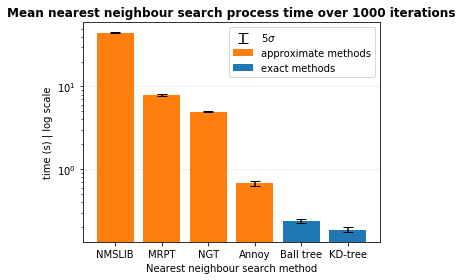

In [74]:
fig, ax = plt.subplots()

# This plots everything together, but I can't make entries for the individual colors
#ax.bar(["nmslib", "mrpt", "ngt", "annoy", "ball tree", "kd-tree"],
#       [nmslib_mean, mrpt_mean, ngt_mean, annoy_mean, ball_mean, kd_mean],
#       yerr=[5*nmslib_std, 5*mrpt_std, 5*ngt_std, 5*annoy_std, 5*ball_std, 5*kd_std],
#       color=['C1','C1','C1','C1',u'#1f77b4',u'#1f77b4'],
#       error_kw={'label': '$5\sigma$', 'capsize': 5})

# Approximate nn methods
ax.bar(["NMSLIB", "MRPT", "NGT", "Annoy"],
       [nmslib_mean, mrpt_mean, ngt_mean, annoy_mean],
       yerr=[5*nmslib_std, 5*mrpt_std, 5*ngt_std, 5*annoy_std],
       color='C1',
       label='approximate methods',
       error_kw={'label': '$5\sigma$', 'capsize': 5})

# Exact methods
ax.bar(["Ball tree", "KD-tree"],
       [ball_mean, kd_mean],
       yerr=[5*ball_std, 5*kd_std],
       color=u'#1f77b4',
       label='exact methods',
       error_kw={'capsize': 5})

ax.set_title("Mean nearest neighbour search process time over 1000 iterations", weight='bold')
ax.set_yscale("log")
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.legend()
ax.set_ylabel("time (s) | log scale")
ax.set_xlabel("Nearest neighbour search method")
fig.tight_layout()

In [76]:
fig.savefig('nearest-neighbours-time-comparison.svg', bbox_inches='tight')

In [78]:
# Values:
print("kd-tree mean: " + str(kd_mean))
print("kd-tree std: " + str(kd_std))

print("ball tree mean: " + str(ball_mean))
print("ball tree std: " + str(ball_std))

print("annoy mean: " + str(annoy_mean))
print("annoy std: " + str(annoy_std))

print("nmslib mean: " + str(nmslib_mean))
print("nmslib std: " + str(nmslib_std))

print("ngt mean: " + str(ngt_mean))
print("ngt std: " + str(ngt_std))

print("mrpt mean: " + str(mrpt_mean))
print("mrpt std: " + str(mrpt_std))

kd-tree mean: 0.18674342801100055
kd-tree std: 0.002277413432554225
ball tree mean: 0.23528463710600142
ball tree std: 0.0026603510409827064
annoy mean: 0.6780599427299913
annoy std: 0.008860050970546903
nmslib mean: 44.85518789950985
nmslib std: 0.04551729026147752
ngt mean: 4.980488702268805
ngt std: 0.014589451692886418
mrpt mean: 7.865359997375998
mrpt std: 0.03521138558884549
